In [11]:
import pandas as pd
import numpy as np
from category_encoders import LeaveOneOutEncoder

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.preprocessing import QuantileTransformer, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import make_pipeline

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
prescaled_df = pd.read_csv('datasets/prescaled_modeling_df.csv').dropna().reset_index(drop=True)# eda feats before manual scaling

In [3]:
# constants
label = 'potential_kwh_total'

cat_features = [
    'is_usa',
    # 'state',
    'approx_zips'
]

numeric_features = [col for col in prescaled_df if col!=label and col not in cat_features]

In [4]:
class CategoricalTransformer(BaseEstimator, TransformerMixin):       
    
    def __init__(self):
        pass

    def fit(self, X, y=None):
        # self.cols = list(X)
        return self
    
    def transform(self, X):
        """Method transforms the type of the columns of passed dataset into category dtype"""
        return X.astype('category')
    
    def get_feature_names_out(self, input_features=None):
        return input_features

    
def set_up_pipeline(numeric_features: list[str], 
                    categorical_features: list[str], 
                    estimator=ElasticNet(alpha=.001, tol=1e-3),
                    poly_power=1):
    """Function that creates data preprocessing pipeline with the passed estimator at the end"""

    pca_pipe = Pipeline(steps=[
        ("scaler", StandardScaler()), 
        ('pca', PCA(n_components=int(len(numeric_features) / 2)))
        ]
    )

    numeric_union = FeatureUnion(transformer_list=[
        ("binariser", QuantileTransformer()),
        ("original", ColumnTransformer([], remainder = 'passthrough')), # done to retreive column names
        ('pca', pca_pipe)
    ])
    
    numeric_transformer = Pipeline(steps=[
        ('numeric_union', numeric_union),
        ('poly', PolynomialFeatures(degree=poly_power)),
        ('scaler', StandardScaler()),
        ]
    )

    
    categorical_transformer = Pipeline(
        steps=[('CategoryTransformer', CategoricalTransformer()), 
               ('encoder', OrdinalEncoder())]  #LeaveOneOutEncoder
    )

    all_feats_transform = ColumnTransformer(
        transformers=[
            ('numeric_transformer', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features),
        ]
    )

    X_pipe = Pipeline(steps=[('preprocessor', all_feats_transform),
                             ('regressor', estimator)])

    return TransformedTargetRegressor(regressor=X_pipe, transformer=StandardScaler())


In [5]:
regr = set_up_pipeline(numeric_features=numeric_features, 
                       categorical_features=cat_features,
                       poly_power=2)

In [6]:
# df with added EDA and transformed features and scaling

df = prescaled_df; label = label
# df = raw_df; label = raw_label

X = df[numeric_features + cat_features]
y = df[label]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

nrmse = np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test)) / np.std(y_test)
r2 = r2_score(y_pred=y_pred, y_true=y_test)

print(f"nrmse: {nrmse:.3}\nr2: {r2:.3}")


nrmse: 0.059
r2: 0.997


In [10]:
coefs = regr.regressor_['regressor'].coef_
X_preprocessed = regr.regressor_['preprocessor'].transform(X)
norm_coefs = np.nan_to_num(coefs / X_preprocessed.std(axis=0))

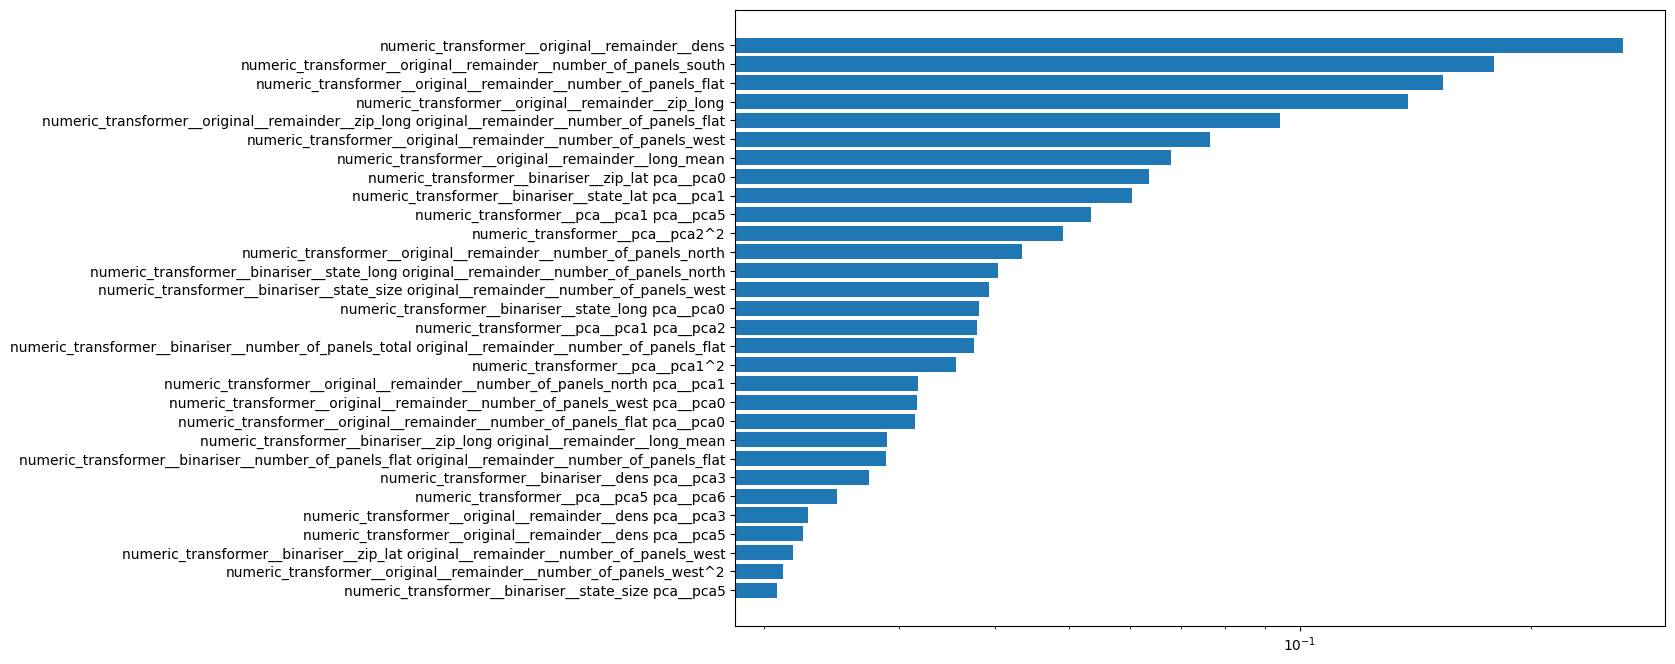

In [47]:
plt.figure(figsize=[12,8])
feat_imp_df = pd.DataFrame(zip(regr.regressor_['preprocessor'].get_feature_names_out(), norm_coefs)).set_index(0).abs().sort_values(1, ascending=False)[:30].sort_values(1)
plt.barh(feat_imp_df.index, feat_imp_df[1])
plt.xscale('log')